In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from datacube import Datacube
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

from sklearn.metrics import f1_score, recall_score, precision_score

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
pd.options.display.max_rows = 50

**Table of contents** <a id="top"></a>
- [Data](#data)
- [Auxiliary functions](#auxiliary)
- [Mapping train linescan to test linescan](#train_test_match)
- [Creating masks](#mask)
- [Prediction](#prediction)

In [3]:
dc = Datacube(app="Getting started")
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

## Data <a id="data"></a>

[Back to top](#top)

In [4]:
train_df = pd.read_csv('resources/challenge1_train.csv', index_col='id')
test_df = pd.read_csv('resources/challenge1_test.csv', index_col='id')
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)

In [5]:
train_df.head()

,label,dateTimeLocal,dateTimeUTC
id,,,
0,ROSEDALE_P1_201901041439_MGA94_55,4/01/2019 14:39,4/01/2019 3:39
1,ROSEDALE_1_P1_201901041446_MGA94_55,4/01/2019 14:46,4/01/2019 3:46
2,ROSEDALE_3_P1_201901041501_MGA94_55,4/01/2019 15:01,4/01/2019 4:01
3,POINT_H_62_P1_201901162128_MGA94_55,16/01/2019 21:28,16/01/2019 10:28
4,NUNNETT_73_P1_201901171134_MGA94_55,17/01/2019 11:34,17/01/2019 0:34


In [6]:
test_df

,label,x,y,dateTimeLocal,dateTimeUTC,target
id,,,,,,
0,JORDAN_235_P1_201901281204_MGA94_55,436123,5826713,28/01/2019 12:04,28/01/2019 1:04,NaN
1,JORDAN_235_P1_201901281204_MGA94_55,435924,5828006,28/01/2019 12:04,28/01/2019 1:04,NaN
2,JORDAN_235_P1_201901281204_MGA94_55,436458,5827661,28/01/2019 12:04,28/01/2019 1:04,NaN
3,JORDAN_235_P1_201901281204_MGA94_55,436166,5828564,28/01/2019 12:04,28/01/2019 1:04,NaN
4,JORDAN_235_P1_201901281204_MGA94_55,436283,5826144,28/01/2019 12:04,28/01/2019 1:04,NaN
...,...,...,...,...,...,...
4995,MACALISTER91_648_P1_201903070444_MGA94_55,478789,5826475,7/03/2019 4:44,6/03/2019 17:44,NaN
4996,MACALISTER91_648_P1_201903070444_MGA94_55,470400,5845253,7/03/2019 4:44,6/03/2019 17:44,NaN
4997,MACALISTER91_648_P1_201903070444_MGA94_55,480548,5842533,7/03/2019 4:44,6/03/2019 17:44,NaN


In [7]:
gdf.head()

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry
0,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-25 22:55:00,2019-01-26 09:55:00,0,Latrobe86,"POLYGON ((431455.605 5829806.837, 431460.570 5..."
1,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 86 - Jericho - Thomson - Jo...,2019-01-25 22:55:00,2019-01-26 09:55:00,1,Latrobe86,"POLYGON ((433874.449 5827986.798, 433882.377 5..."
2,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 85 - Jericho - Cream Can Hill,2019-01-25 22:55:00,2019-01-26 09:55:00,2,Latrobe86,"POLYGON ((430459.914 5831285.492, 430457.641 5..."
3,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Spot,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,3,Latrobe86,"POLYGON ((431937.376 5829943.371, 431941.068 5..."
4,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Main run,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,2019-01-26 06:50:00,2019-01-26 17:50:00,4,Latrobe86,"POLYGON ((431541.651 5829804.025, 431547.139 5..."


## Auxiliary functions <a id="auxiliary"></a>

[Back to top](#top)

In [8]:
def get_linescan(index=None, label=None, resolution=(-10,10), linescan_datasets=linescan_datasets):
    """
    :param id:
    :param label:
    :param resolution:
    :param linescan_datasets:
    :return:
    """
    
    if index is not None:
        linescan = dc.load(product='linescan', id=linescan_datasets[index].id, 
                           output_crs='epsg:28355', resolution=resolution).linescan

        return linescan
    
    if label is not None:
        linescan = dc.load(product='linescan', label=label, 
                           output_crs='epsg:28355', resolution=resolution).linescan
        return linescan
    
    return None

def plot_train_data(index=None, label=None, resolution=(-10,10), linescan_datasets=linescan_datasets, ax=None):
    """
    :param id:
    :param label:
    :param resolution:
    :param linescan_datasets:
    :return:
    """
    linescan = get_linescan(index, label, resolution, linescan_datasets)
    linescan.plot(ax=ax)
    
def clean_name(name):
    """
    :param name:
    :return:
    """
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res
    
    
    
def plot_test_data(fname=None, figsize=(15,15), gdf=gdf):
    """
    :param fname:
    :param figsize:
    :param gdf:
    :return:
    """
    
    ob = gdf.loc[gdf.SourceNameClean == fname]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ob.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)
    
def plot_test_on_train(train_name, test_name, figsize=(15,15), gdf=gdf):
    """
    """
    
    ob = gdf.loc[gdf.SourceNameClean == test_name]
    src = get_linescan(label=train_name)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    src.plot(ax=ax)
    ob.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)
    
def plot_test_and_train(train_name, test_name, figsize=(15,15), gdf=gdf):
    """
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    src = get_linescan(label=train_name)
    src.plot(ax=ax[0])
    ax[0].set_title('Source: linescan')
    
    ob = gdf.loc[gdf.SourceNameClean == test_name]
    tgt = xr_rasterize(gdf=ob, da=src)
    tgt.plot(ax=ax[1])
    ax[1].set_title('Target: ground truth mask')



[Back to top](#top)

## Mapping train linescan to test linescan <a id="train_test_match"></a>

[Back to top](#top)

In [9]:
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)

In [10]:
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]
list(composites.SourceNameClean.unique())

/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)',
 'MACALISTER_681_&_682,_(684_&_685_MINOR)_COMPOSITE_0517-0539HRS',
 'COMPOSITE_MACALISTER97_803,_806_&__807_1455-1532HRS',
 'MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS',
 'MACALISTER91_766,767_&_770_COMPOSITE_1239-1314HRS',
 'MACALISTER91_775,_776,_779_&_783_COMPOSITE_1345-1643HRS',
 'MACALISTER91_789,_790_&_793_COMPOSITE_1330-1358HRS',
 'MACALISTER91_804,_805_&_808_COMPOSITE_1503-1539HRS',
 'MACALISTER91_646,648_&_649_COMPOSITE_-_0440HRS_TO_0453HRS',
 'MACALISTER_695,698_&_699_COMPOSITE_1542_-_1610HRS',
 'MACALISTER_696,697,700_-_1545-1613HRS',
 'COMPOSITE_WALLHALLA_380_&_381_20190206_(1347_&_1356HRS)']

In [11]:
label_to_srcname_dict = {}

for i in range(len(train_df)):
    label = train_df.label[i]
    
    if label in set(gdf.SourceNameClean):
        label_to_srcname_dict[label] = label
    else:
        label_to_srcname_dict[label] = None

Manual matching of composite polygons to their corresponding training data.

In [12]:
label_to_srcname_dict["WALHALLA_397_P1_201902251311_MGA94_55"] = "COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)"
label_to_srcname_dict["WALHALLA_398_P1_201902251323_MGA94_55"] = "COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)"
label_to_srcname_dict["WALHALLA_401_P1_201902251342_MGA94_55"] = "COMPOSITE_WALLHALLA_397,398_&_401_20190225_(1311_TO_1342HRS)"

label_to_srcname_dict["MACALISTER91_681_P1_201903080517_MGA94_55"] = "MACALISTER_681_&_682,_(684_&_685_MINOR)_COMPOSITE_0517-0539HRS"
label_to_srcname_dict["MACALISTER91_682_P1_201903080526_MGA94_55"] = "MACALISTER_681_&_682,_(684_&_685_MINOR)_COMPOSITE_0517-0539HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER85_684_P1_201903080536_MGA94_55"] = "MACALISTER_681_&_682,_(684_&_685_MINOR)_COMPOSITE_0517-0539HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_685_P1_201903080539_MGA94_55"] = "MACALISTER_681_&_682,_(684_&_685_MINOR)_COMPOSITE_0517-0539HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER97_803_P1_201903161455_MGA94_55"] = "COMPOSITE_MACALISTER97_803,_806_&__807_1455-1532HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER97_806_P1_201903161522_MGA94_55"] = "COMPOSITE_MACALISTER97_803,_806_&__807_1455-1532HRS"
label_to_srcname_dict["MACALISTER97_807_P1_201903161532_MGA94_55"] = "COMPOSITE_MACALISTER97_803,_806_&__807_1455-1532HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER91_752_P1_201903111601_MGA94_55"] = "MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_755_P1_201903111619_MGA94_55"] = "MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_760_P1_201903111709_MGA94_55"] = "MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_761_P1_201903111720_MGA94_55"] = "MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_762_P1_201903111730_MGA94_55"] = "MACALISTER91_751,_752,_755,_760,_761_&_762_COMPOSITE_1549-1730HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER91_766_P1_201903131239_MGA94_55"] = "MACALISTER91_766,767_&_770_COMPOSITE_1239-1314HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_767_P1_201903131252_MGA94_55"] = "MACALISTER91_766,767_&_770_COMPOSITE_1239-1314HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_770_P1_201903131314_MGA94_55"] = "MACALISTER91_766,767_&_770_COMPOSITE_1239-1314HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER91_783_P1_201903141643_MGA94_55"] = "MACALISTER91_775,_776,_779_&_783_COMPOSITE_1345-1643HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER91_789_P1_201903151330_MGA94_55"] = "MACALISTER91_789,_790_&_793_COMPOSITE_1330-1358HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_790_P1_201903151340_MGA94_55"] = "MACALISTER91_789,_790_&_793_COMPOSITE_1330-1358HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_793_P1_201903151358_MGA94_55"] = "MACALISTER91_789,_790_&_793_COMPOSITE_1330-1358HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER91_804_P1_201903161503_MGA94_55"] = "MACALISTER91_804,_805_&_808_COMPOSITE_1503-1539HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_805_P1_201903161517_MGA94_55"] = "MACALISTER91_804,_805_&_808_COMPOSITE_1503-1539HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER91_808_P1_201903161539_MGA94_55"] = "MACALISTER91_804,_805_&_808_COMPOSITE_1503-1539HRS"

label_to_srcname_dict["MACALISTER91_99_649_P1_201903070453_MGA94_55"] = "MACALISTER91_646,648_&_649_COMPOSITE_-_0440HRS_TO_0453HRS"

label_to_srcname_dict["MACALISTER_695_P1_201903091542_MGA94_55"] = "MACALISTER_695,698_&_699_COMPOSITE_1542_-_1610HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER_698_P1_201903091600_MGA94_55"] = "MACALISTER_695,698_&_699_COMPOSITE_1542_-_1610HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER_699_P1_201903091610_MGA94_55"] = "MACALISTER_695,698_&_699_COMPOSITE_1542_-_1610HRS"

# pretty bad match
label_to_srcname_dict["MACALISTER_696_P1_201903091545_MGA94_55"] = "MACALISTER_696,697,700_-_1545-1613HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER_697_P1_201903091555_MGA94_55"] = "MACALISTER_696,697,700_-_1545-1613HRS"
# pretty bad match
label_to_srcname_dict["MACALISTER_700_P1_201903091613_MGA94_55"] = "MACALISTER_696,697,700_-_1545-1613HRS"

# pretty bad match
label_to_srcname_dict["WALHALLA_380_P1_201902061347_MGA94_55"] = "COMPOSITE_WALLHALLA_380_&_381_20190206_(1347_&_1356HRS)"
# pretty bad match
label_to_srcname_dict["WALHALLA_381_P1_201902061356_MGA94_55"] = "COMPOSITE_WALLHALLA_380_&_381_20190206_(1347_&_1356HRS)"


In [13]:
label_to_srcname_dict

{'ROSEDALE_P1_201901041439_MGA94_55': None,
 'ROSEDALE_1_P1_201901041446_MGA94_55': None,
 'ROSEDALE_3_P1_201901041501_MGA94_55': None,
 'POINT_H_62_P1_201901162128_MGA94_55': None,
 'NUNNETT_73_P1_201901171134_MGA94_55': None,
 'NUNNETT_88_P1_201901171656_MGA94_55': None,
 'NUNNETT_96_P1_201901172230_MGA94_55': None,
 'NUNNETT_107_P1_201901181517_MGA94_55': None,
 'NUNNETT_121_P1_201901191642_MGA94_55': None,
 'NUNNETT_128_P1_201901192201_MGA94_55': None,
 'NUNNETT_173_P1_201901251120_MGA94_55': None,
 'NUNNETT_174_P1_201901251128_MGA94_55': None,
 'NUNNETT_175_P1_201901251137_MGA94_55': None,
 'NUNNETT_176_P1_201901251157_MGA94_55': None,
 'NUNNETT_177_P1_201901251211_MGA94_55': None,
 'NUNNETT_179_P1_201901251234_MGA94_55': None,
 'NUNNETT_180_P1_201901251246_MGA94_55': None,
 'NUNNETT_181_P1_201901251254_MGA94_55': None,
 'NUNNETT_182_P1_201901251321_MGA94_55': None,
 'NUNNETT_183_P1_201901251342_MGA94_55': None,
 'NUNNETT_184_P1_201901251400_MGA94_55': None,
 'NUNNETT_185_P1_20190

Manual matching of other geo-polygons to training data

In [14]:
label_to_srcname_dict["MACALISTER_696_P1_201903091545_MGA94_55"] = "MACALISTER_696_P1_201903091545_MGA94_55"
label_to_srcname_dict["MACALISTER91_621_P1_201903051827_MGA94_55"] = "MACALISTER91_WIDE_VIEW_621_P1_201903051827_MGA94_55"
label_to_srcname_dict["MACALISTER_700_P1_201903091613_MGA94_55"] = "MACALISTER_700_P1_201903091613_MGA94_55"

## Creating masks <a id="mask"></a>

[Back to top](#top)

In [15]:
def get_threshold_mask(linescan, threshold=200):
    """
    
    """
    
    our_mask = linescan>threshold
    
    return our_mask

def plot_masks(pred_mask, tgt_mask, figsize=(15,5)):
    """
    
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    pred_mask.plot(ax=ax[0])
    ax[0].set_title('Prediction: our mask')

    tgt_mask.plot(ax=ax[1])
    ax[1].set_title('Target: ground truth mask')

Rasterizing to match xarray.DataArray dimensions (1908, 2142)


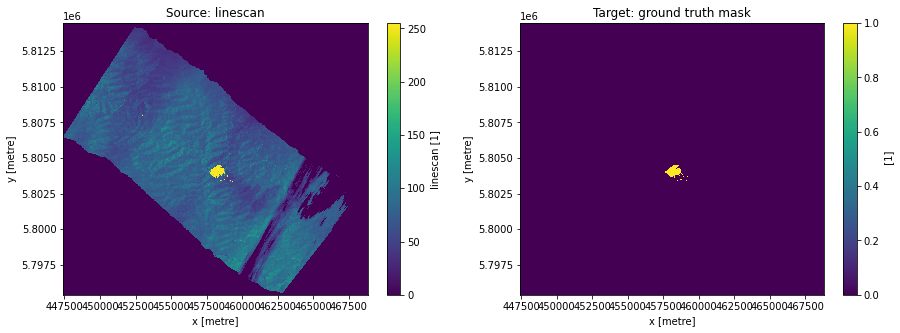

In [16]:
plot_test_and_train(train_name="MCCALLISTER79_LA_TROBE_97_266_P1_201901301552_MGA94_55",
                    test_name=label_to_srcname_dict["MCCALLISTER79_LA_TROBE_97_266_P1_201901301552_MGA94_55"])

Rasterizing to match xarray.DataArray dimensions (1908, 2142)


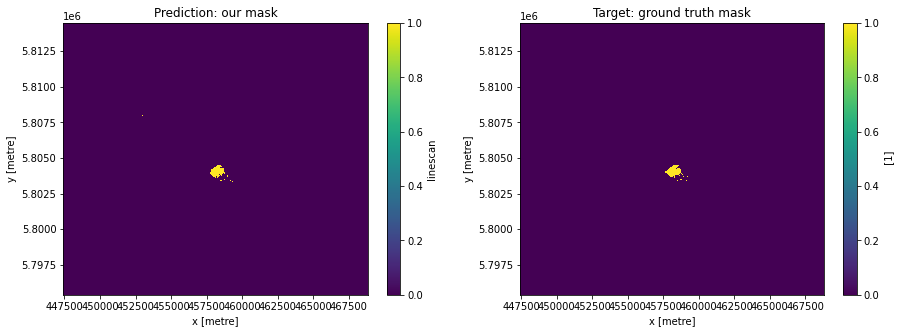

In [17]:
label = "MCCALLISTER79_LA_TROBE_97_266_P1_201901301552_MGA94_55"

src = get_linescan(label=label)
ob = gdf.loc[gdf.SourceNameClean == label_to_srcname_dict[label]]

tgt = xr_rasterize(gdf=ob, da=src)

plot_masks(pred_mask=get_threshold_mask(src),
           tgt_mask=tgt)

- `Precision = TP / (TP + FP)`, so **precision** is high when false positive is low.
- `Recall = TP / (TP + FN)`, so **recall** is high when false negative is low.

In [18]:
def perf_metric(y_true, y_pred, metric="f1"):
    """
    :param y_true: 1d array of binary data representing ground truth
    :param y_pred: 1d array of binary data representing predictions
    """
    
    if metric == "true_pos":
        return sum((y_true == 1) & (y_pred == 1))
    
    if metric == "true_neg":
        return sum((y_true == 0) & (y_pred == 0))
    
    if metric == "false_pos":
        return sum((y_true == 0) & (y_pred == 1))
    
    if metric == "false_neg":
        return sum((y_true == 1) & (y_pred == 0))
    
    
    if metric == "f1":
        return f1_score(y_true=y_true, y_pred=y_pred, pos_label=1)
    
    if metric == "precision":
        return precision_score(y_true=y_true, y_pred=y_pred, pos_label=1)
    
    if metric == "recall":
        return recall_score(y_true=y_true, y_pred=y_pred, pos_label=1)

In [19]:
label = "ABERFELDY_WEST_200_P1_201901260955_MGA94_55"
src = get_linescan(label=label)
ob = gdf.loc[gdf.SourceNameClean == label_to_srcname_dict[label]]
tgt = xr_rasterize(gdf=ob, da=src)
pred_mask = get_threshold_mask(src)

y_pred = np.ndarray.flatten(pred_mask.data[0])
y_true = np.ndarray.flatten(tgt.data)

f1 = perf_metric(y_true=y_true, y_pred=y_pred, metric="f1")
recall = perf_metric(y_true=y_true, y_pred=y_pred, metric="recall")
precision = perf_metric(y_true=y_true, y_pred=y_pred, metric="precision")

print(f"precision score: {f1}")
print(f"recall score: {recall}")
print(f"f1 score: {precision}")

Rasterizing to match xarray.DataArray dimensions (777, 1171)
precision score: 0.4965104685942174
recall score: 0.33557951482479786
f1 score: 0.9540229885057471


In [20]:
eval_df = pd.DataFrame(columns=["label", "source_name", "f1", "recall", "precision"])
eval_df

,label,source_name,f1,recall,precision


In [21]:
label_to_srcname_dict["ABERFELDY_WEST_200_P1_201901260955_MGA94_55"]

'ABERFELDY_WEST_200_P1_201901260955_MGA94_55'

In [ ]:
%%time

for label in label_to_srcname_dict:
    src_name = label_to_srcname_dict[label]
    
    if src_name is not None:
        src = get_linescan(label=label)
        ob = gdf.loc[gdf.SourceNameClean == src_name]
        tgt = xr_rasterize(gdf=ob, da=src)
        pred_mask = get_threshold_mask(src)
        
        # performance metric
        y_pred = np.ndarray.flatten(pred_mask.data[0])
        y_true = np.ndarray.flatten(tgt.data)
        
        f1 = perf_metric(y_true=y_true, y_pred=y_pred, metric="f1")
        recall = perf_metric(y_true=y_true, y_pred=y_pred, metric="recall")
        precision = perf_metric(y_true=y_true, y_pred=y_pred, metric="precision")
        
        eval_df.loc[len(eval_df), :] = [label, src_name, f1, recall, precision]

In [ ]:
eval_df.sort_values(by="f1", ascending=False).dropna().head(20)

## Prediction <a id="prediction"></a>

[Back to top](#top)

A look at the test linescans, there are 5 in total

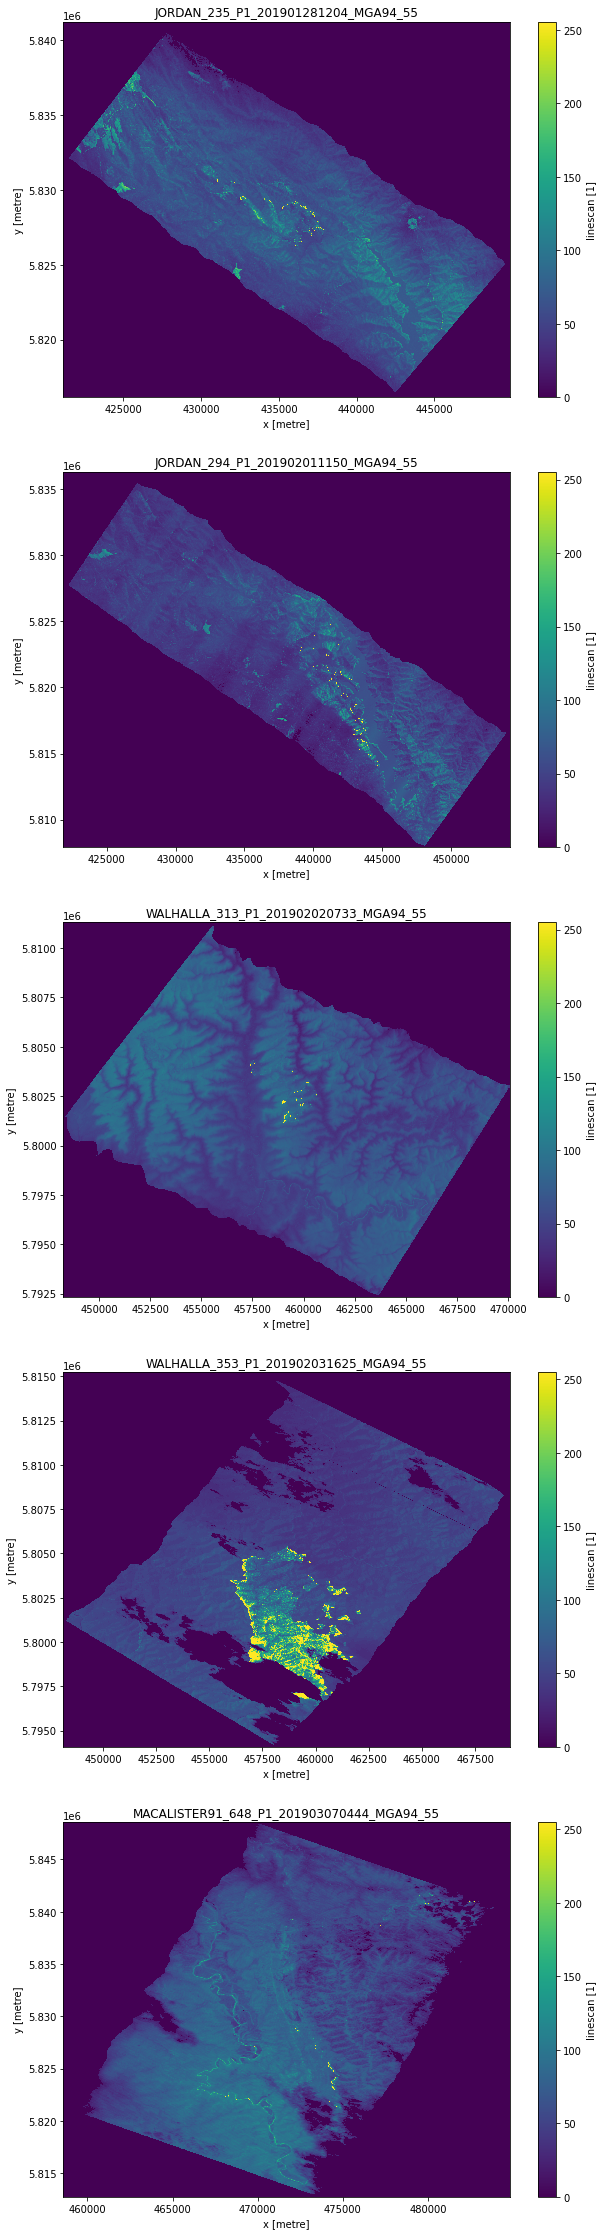

In [22]:
test_labels = test_df.label.unique()
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,40))

for i in range(len(test_labels)):
    label = test_labels[i]
    linescan = get_linescan(label=test_labels[i])
    
    linescan.plot(ax=ax[i])
    ax[i].set_title(label)

In [23]:
print(test_labels)

['JORDAN_235_P1_201901281204_MGA94_55'
 'JORDAN_294_P1_201902011150_MGA94_55'
 'WALHALLA_313_P1_201902020733_MGA94_55'
 'WALHALLA_353_P1_201902031625_MGA94_55'
 'MACALISTER91_648_P1_201903070444_MGA94_55']


In [44]:
for train_label in train_df.label.unique():
    if "MACAL" in train_label.upper() and label_to_srcname_dict[train_label]:
        print(train_label)

MACALISTER_695_P1_201903091542_MGA94_55
MACALISTER_696_P1_201903091545_MGA94_55
MACALISTER_697_P1_201903091555_MGA94_55
MACALISTER_698_P1_201903091600_MGA94_55
MACALISTER_699_P1_201903091610_MGA94_55
MACALISTER_700_P1_201903091613_MGA94_55
MACALISTER85_624_P1_201903051907_MGA94_55
MACALISTER85_684_P1_201903080536_MGA94_55
MACALISTER85_723_P1_201903100101_MGA94_55
MACALISTER87_719_P1_201903100033_MGA94_55
MACALISTER91_615_P1_201903051438_MGA94_55
MACALISTER91_621_P1_201903051827_MGA94_55
MACALISTER91_681_P1_201903080517_MGA94_55
MACALISTER91_682_P1_201903080526_MGA94_55
MACALISTER91_685_P1_201903080539_MGA94_55
MACALISTER91_752_P1_201903111601_MGA94_55
MACALISTER91_755_P1_201903111619_MGA94_55
MACALISTER91_760_P1_201903111709_MGA94_55
MACALISTER91_761_P1_201903111720_MGA94_55
MACALISTER91_762_P1_201903111730_MGA94_55
MACALISTER91_766_P1_201903131239_MGA94_55
MACALISTER91_767_P1_201903131252_MGA94_55
MACALISTER91_770_P1_201903131314_MGA94_55
MACALISTER91_783_P1_201903141643_MGA94_55
MACA

Text(0.5, 1.0, 'MACALISTER91_648_P1_201903070444_MGA94_55')

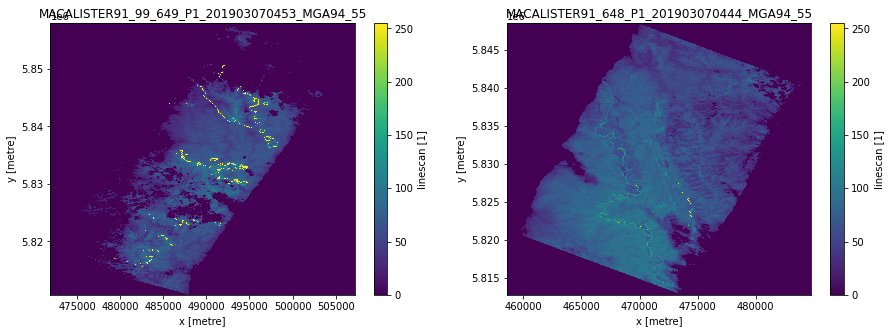

In [47]:
train_label = "MACALISTER91_99_649_P1_201903070453_MGA94_55"
test_label = "MACALISTER91_648_P1_201903070444_MGA94_55"

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_train_data(label=train_label, ax=ax[0])
ax[0].set_title(train_label)

plot_train_data(label=test_label, ax=ax[1])
ax[1].set_title(test_label)

Text(0.5, 1.0, 'MACALISTER91_648_P1_201903070444_MGA94_55')

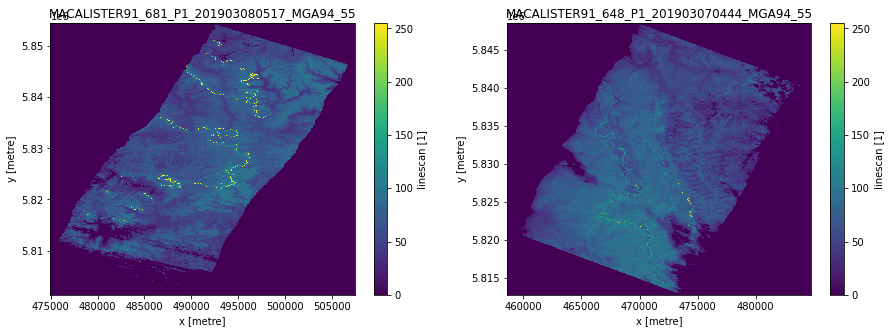

In [46]:
train_label = "MACALISTER91_681_P1_201903080517_MGA94_55"
test_label = "MACALISTER91_648_P1_201903070444_MGA94_55"

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_train_data(label=train_label, ax=ax[0])
ax[0].set_title(train_label)

plot_train_data(label=test_label, ax=ax[1])
ax[1].set_title(test_label)

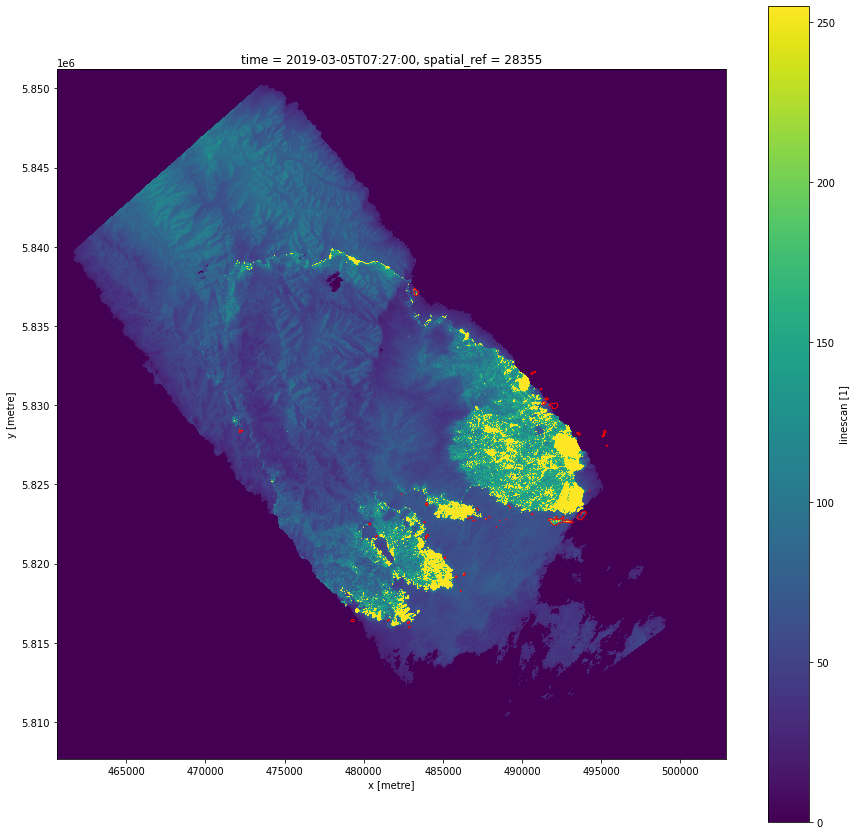

In [48]:
train_label = "MACALISTER91_621_P1_201903051827_MGA94_55"
plot_test_on_train(train_name=train_label,
                   test_name=label_to_srcname_dict[train_label])

In [29]:
test_to_similar = {}

test_to_similar["JORDAN_235_P1_201901281204_MGA94_55"] = "JORDAN_234_P1_201901271901_MGA94_55"
test_to_similar["JORDAN_294_P1_201902011150_MGA94_55"] = "JORDAN_310_P1_201902012046_MGA94_55"
test_to_similar["WALHALLA_313_P1_201902020733_MGA94_55"] = "WALHALLA_339_P1_201902030520_MGA94_55"
test_to_similar["WALHALLA_353_P1_201902031625_MGA94_55"] = None # none fits
test_to_similar["MACALISTER91_648_P1_201903070444_MGA94_55"] = None
    
test_to_similar

{'JORDAN_235_P1_201901281204_MGA94_55': None,
 'JORDAN_294_P1_201902011150_MGA94_55': 'WALHALLA_295_P1_201902011156_MGA94_55',
 'WALHALLA_313_P1_201902020733_MGA94_55': 'WALHALLA_339_P1_201902030520_MGA94_55',
 'WALHALLA_353_P1_201902031625_MGA94_55': None,
 'MACALISTER91_648_P1_201903070444_MGA94_55': None}